In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

def _wrp(row, model):
    s = simi.pairwise_cosine_similarity(simi.model_embeddings(model, [row["a"], row["p"], row["n"]]))[0]
    if s[1] > s[0]:
        return (*s, 0)
    return (*s, 1)

# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    ap_scores, an_scores, labels = zip(*df.progress_apply(lambda r: _wrp(r, model), axis=1))
    ap_scores = pd.Series(ap_scores, index=df.index, name=name+" a-p")
    an_scores = pd.Series(an_scores, index=df.index, name=name+" a-n")
    labels = pd.Series(labels, index=df.index, name="label")
    if append:
        df = df.merge(ap_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(an_scores.to_frame(), left_index=True, right_index=True)
        df = df.merge(labels.to_frame(), left_index=True, right_index=True)
        return df
    return ap_scores, an_scores, labels

2024-01-07 14:39:43.452110: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("anchor-arxiv-dataset.csv", index_col=0)
df.sample(5)

,title,abstract,categories,doi,a,p,n
58921,Spectra of Bernoulli convolutions as multiplie...,It is shown that the closure of the set of F...,"('math.FA', 'math.DS', 'math.NT')",NaN,We show that such a set is still countable for...,We also consider the sets $\bar{\{\hat{\mu_\th...,I consider the Diophantine approximation prob...
46602,Amalgmation in Boolean algebras with operators,We study various forms of amalgamation for B...,"('math.LO',)",NaN,We study various forms of amalgamation for Bo...,We will also have the occasion to weaken the B...,Moreover I give a pure combinatorial descripti...
22537,End Super Dominating Sets in Graphs,"Let $G=(V,E)$ be a simple graph. A dominatin...","('math.CO',)",NaN,A super dominating set is a dominating set $S$...,We give applications of end super dominating s...,We show a correspondence between restricted pe...
76740,Hutchings' inequality for the Calabi invariant...,"In [Hut16], Hutchings uses embedded contact ...","('math.SG', 'math.DS')",NaN,"In [Hut16], Hutchings uses embedded contact h...","As an application, we show that the Calabi inv...",We study the existence of symplectic resoluti...
81411,Cultures as networks of cultural traits: A uni...,Making use of the information from the World...,"('stat.AP', 'physics.soc-ph')",NaN,Making use of the information from the World ...,The Jeffreys' divergence between copula graphi...,"Furthermore, we propose a novel extension of t..."


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 73760 eval: 9221 test: 9221


## Model definitions

In [4]:
# combine models into dict
eval_models = {
    "BERT+CLS+ANCH-ARX": SentenceTransformer('./bert+cls+retrain_anchor_arxiv'),
    "BERT+MP+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+retrain_anchor_arxiv'),
    "BERT+CLS+CLASS-ARX": SentenceTransformer('./bert+cls+retrain_class_arxiv'),
    "BERT+MP+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "BERT+CLS+CLASS-ZBM": SentenceTransformer('./bert+cls+retrain_class_zbmath'),
    "BERT+MP+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "SBERT+MP+ANCH-ARX": SentenceTransformer('./sbert+retrain_anchor_arxiv'),
    "SBERT+MP+CLASS-ARX": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBERT+MP+CLASS-ZBM": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "MathBERT+CLS+ANCH-ARX": SentenceTransformer('./mathbert+cls+retrain_anchor_arxiv'),
    "MathBERT+MP+ANCH-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_anchor_arxiv'),
    "MathBERT+CLS+CLASS-ARX": SentenceTransformer('./mathbert+cls+retrain_class_arxiv'),
    "MathBERT+MP+CLASS-ARX": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "MathBERT+CLS+CLASS-ZBM": SentenceTransformer('./mathbert+cls+retrain_class_zbmath'),
    "MathBERT+MP+CLASS-ZBM": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "SPECTER2+CLS+ANCH-ARX": SentenceTransformer('./specter2+cls+retrain_anchor_arxiv'),
    "SPECTER2+MP+ANCH-ARX": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv'),
    "SPECTER2+CLS+CLASS-ARX": SentenceTransformer('./specter2+cls+retrain_class_arxiv'),
    "SPECTER2+MP+CLASS-ARX": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "SPECTER2+CLS+CLASS-ZBM": SentenceTransformer('./specter2+cls+retrain_class_zbmath'),
    "SPECTER2+MP+CLASS-ZBM": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    
    "SGPT+ANCH-ARX": SentenceTransformer('./gpt+retrain_anchor_arxiv'),
    "SGPT+CLASS-ARX": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+CLASS-ZBM": SentenceTransformer('./gpt+retrain_class_zbmath'),
    
    "BERT+MLM+CLS+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_anchor_arxiv'),
    "BERT+MLM+MP+ANCH-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_anchor_arxiv'),
    "BERT+MLM+CLS+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_arxiv'),
    "BERT+MLM+MP+CLASS-ARX": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "BERT+MLM+CLS+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+cls+retrain_class_zbmath'),
    "BERT+MLM+MP+CLASS-ZBM": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    
    "BERT+CLS+TSDAE+ANCH-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+MP+TSDAE+ANCH-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_anchor_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ARX": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+MP+TSDAE+CLASS-ARX": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "BERT+CLS+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    "BERT+MP+TSDAE+CLASS-ZBM": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
}

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["a"], r["p"], r["n"]]), axis=1)
evaluator = evaluation.TripletEvaluator.from_input_examples(eval_examples, batch_size=32, main_distance_function=0, show_progress_bar=True)

In [6]:
%%time
eval_results = {}

with tqdm(total=len(eval_models), desc="Models") as pb:
    for n,m in eval_models.items():
        eval_results[n] = [m.evaluate(evaluator)]
        pb.update()

eval_result_df = pd.DataFrame(eval_results)

Models:   0%|          | 0/36 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

Batches:   0%|          | 0/289 [00:00<?, ?it/s]

CPU times: user 2h 13min 15s, sys: 5min 57s, total: 2h 19min 12s
Wall time: 31min 17s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
eval_result_df

,BERT+CLS+ANCH-ARX,BERT+MP+ANCH-ARX,BERT+CLS+CLASS-ARX,BERT+MP+CLASS-ARX,BERT+CLS+CLASS-ZBM,BERT+MP+CLASS-ZBM,SBERT+MP+ANCH-ARX,SBERT+MP+CLASS-ARX,SBERT+MP+CLASS-ZBM,MathBERT+CLS+ANCH-ARX,MathBERT+MP+ANCH-ARX,MathBERT+CLS+CLASS-ARX,MathBERT+MP+CLASS-ARX,MathBERT+CLS+CLASS-ZBM,MathBERT+MP+CLASS-ZBM,SPECTER2+CLS+ANCH-ARX,SPECTER2+MP+ANCH-ARX,SPECTER2+CLS+CLASS-ARX,SPECTER2+MP+CLASS-ARX,SPECTER2+CLS+CLASS-ZBM,SPECTER2+MP+CLASS-ZBM,SGPT+ANCH-ARX,SGPT+CLASS-ARX,SGPT+CLASS-ZBM,BERT+MLM+CLS+ANCH-ARX,BERT+MLM+MP+ANCH-ARX,BERT+MLM+CLS+CLASS-ARX,BERT+MLM+MP+CLASS-ARX,BERT+MLM+CLS+CLASS-ZBM,BERT+MLM+MP+CLASS-ZBM,BERT+CLS+TSDAE+ANCH-ARX,BERT+MP+TSDAE+ANCH-ARX,BERT+CLS+TSDAE+CLASS-ARX,BERT+MP+TSDAE+CLASS-ARX,BERT+CLS+TSDAE+CLASS-ZBM,BERT+MP+TSDAE+CLASS-ZBM
0,0.856848,0.850125,0.664136,0.686585,0.761414,0.776814,0.727687,0.697864,0.798178,0.87908,0.883744,0.68344,0.676499,0.769006,0.778007,0.895998,0.898384,0.665329,0.66945,0.772042,0.7792,0.866067,0.709251,0.794599,0.901204,0.899794,0.707082,0.701876,0.805661,0.813795,0.8665,0.864874,0.662184,0.664787,0.774536,0.786899


## Cosine-Similarity for test data

In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        ap_scores, an_scores, labels = st_similarity_scoring(X_test, m)
        X_test_score["cos-sim (a--p {})".format(n)] = ap_scores
        X_test_score["cos-sim (a--n {})".format(n)] = an_scores
        X_test_score["label ({})".format(n)] = labels
        pb.update()

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

  0%|          | 0/9221 [00:00<?, ?it/s]

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/9221 [00:00<?, ?it/s]

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/9221 [00:00<?, ?it/s]

CPU times: user 3h 38min 21s, sys: 3min 21s, total: 3h 41min 42s
Wall time: 59min 17s


<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [11]:
X_test_score.describe()

,cos-sim (a--p BERT+CLS+ANCH-ARX),cos-sim (a--n BERT+CLS+ANCH-ARX),label (BERT+CLS+ANCH-ARX),cos-sim (a--p BERT+MP+ANCH-ARX),cos-sim (a--n BERT+MP+ANCH-ARX),label (BERT+MP+ANCH-ARX),cos-sim (a--p BERT+CLS+CLASS-ARX),cos-sim (a--n BERT+CLS+CLASS-ARX),label (BERT+CLS+CLASS-ARX),cos-sim (a--p BERT+MP+CLASS-ARX),cos-sim (a--n BERT+MP+CLASS-ARX),label (BERT+MP+CLASS-ARX),cos-sim (a--p BERT+CLS+CLASS-ZBM),cos-sim (a--n BERT+CLS+CLASS-ZBM),label (BERT+CLS+CLASS-ZBM),cos-sim (a--p BERT+MP+CLASS-ZBM),cos-sim (a--n BERT+MP+CLASS-ZBM),label (BERT+MP+CLASS-ZBM),cos-sim (a--p SBERT+MP+ANCH-ARX),cos-sim (a--n SBERT+MP+ANCH-ARX),...,cos-sim (a--n BERT+MLM+MP+CLASS-ZBM),label (BERT+MLM+MP+CLASS-ZBM),cos-sim (a--p BERT+CLS+TSDAE+ANCH-ARX),cos-sim (a--n BERT+CLS+TSDAE+ANCH-ARX),label (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (a--p BERT+MP+TSDAE+ANCH-ARX),cos-sim (a--n BERT+MP+TSDAE+ANCH-ARX),label (BERT+MP+TSDAE+ANCH-ARX),cos-sim (a--p BERT+CLS+TSDAE+CLASS-ARX),cos-sim (a--n BERT+CLS+TSDAE+CLASS-ARX),label (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (a--p BERT+MP+TSDAE+CLASS-ARX),cos-sim (a--n BERT+MP+TSDAE+CLASS-ARX),label (BERT+MP+TSDAE+CLASS-ARX),cos-sim (a--p BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (a--n BERT+CLS+TSDAE+CLASS-ZBM),label (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (a--p BERT+MP+TSDAE+CLASS-ZBM),cos-sim (a--n BERT+MP+TSDAE+CLASS-ZBM),label (BERT+MP+TSDAE+CLASS-ZBM)
count,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,...,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000,9221.000000
mean,0.511221,0.161481,0.852402,0.502475,0.135735,0.847739,0.673428,0.520147,0.664136,0.679516,0.526736,0.686585,0.600727,0.385343,0.761414,0.589028,0.369216,0.776814,0.513752,0.106866,...,0.345512,0.813795,0.536085,0.202246,0.864223,0.528503,0.173716,0.860427,0.597473,0.431968,0.662184,0.611915,0.446462,0.664787,0.590992,0.354291,0.774536,0.587124,0.352894,0.786899
std,0.239261,0.237569,0.354720,0.250519,0.261873,0.359293,0.286084,0.316746,0.472317,0.250637,0.278057,0.463907,0.219774,0.210945,0.426242,0.215409,0.204025,0.416405,0.587406,0.639412,...,0.217047,0.389293,0.218922,0.213982,0.342570,0.231222,0.227835,0.346562,0.342729,0.356973,0.472991,0.316390,0.331111,0.472091,0.230978,0.217133,0.417910,0.221409,0.201026,0.409520
min,-0.422219,-0.526880,0.000000,-0.549858,-0.625015,0.000000,-0.074292,-0.136132,0.000000,-0.121790,-0.157913,0.000000,-0.160703,-0.288804,0.000000,-0.116486,-0.255048,0.000000,-0.955848,-0.951246,...,-0.178785,0.000000,-0.365805,-0.434516,0.000000,-0.453497,-0.509883,0.000000,-0.084990,-0.130893,0.000000,-0.076602,-0.126741,0.000000,-0.147498,-0.270937,0.000000,-0.179037,-0.198599,0.000000
25%,0.348950,-0.011261,1.000000,0.339593,-0.052372,1.000000,0.455519,0.239730,0.000000,0.503756,0.300012,0.000000,0.445006,0.232565,1.000000,0.436241,0.217680,1.000000,0.151218,-0.440914,...,0.179784,1.000000,0.389577,0.048663,1.000000,0.376728,0.008739,1.000000,0.277639,0.096610,0.000000,0.334556,0.137196,0.000000,0.425265,0.194888,1.000000,0.423058,0.206543,1.000000
50%,0.544237,0.154999,1.000000,0.540164,0.133511,1.000000,0.759042,0.524369,1.000000,0.738242,0.538297,1.000000,0.613774,0.385196,1.000000,0.600033,0.367227,1.000000,0.813147,0.100620,...,0.329064,1.000000,0.564201,0.199139,1.000000,0.558291,0.165799,1.000000,0.667641,0.343103,1.000000,0.684265,0.401279,1.000000,0.608047,0.346387,1.000000,0.599224,0.344038,1.000000
75%,0.696877,0.326790,1.000000,0.696284,0.319216,1.000000,0.927698,0.817789,1.000000,0.897018,0.768274,1.000000,0.778666,0.537726,1.000000,0.760731,0.512385,1.000000,0.970039,0.742148,...,0.495468,1.000000,0.705255,0.355464,1.000000,0.707840,0.335211,1.000000,0.936338,0.798080,1.000

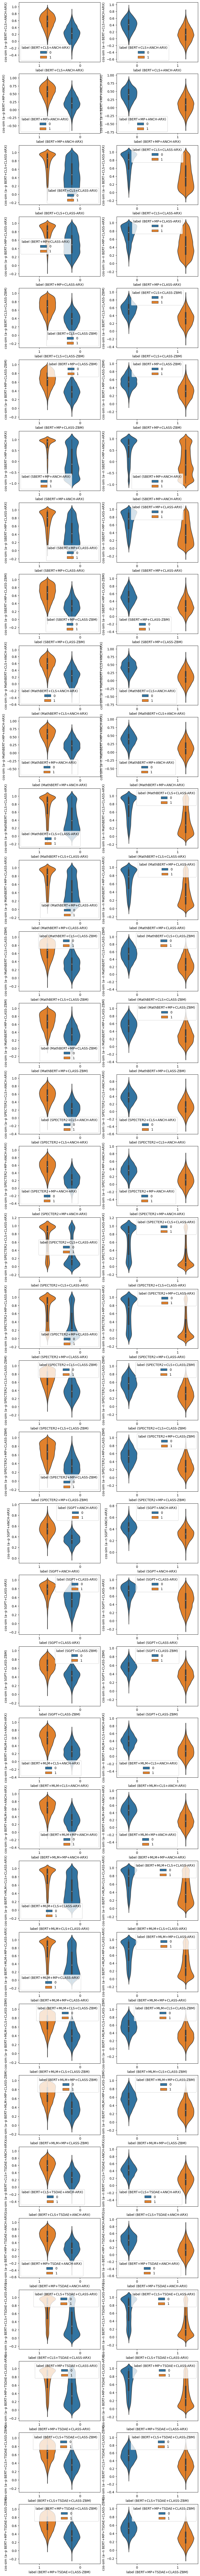

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], scale="count", scale_hue=True, ax=axs[i][0])
    sns.violinplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), scale="count", scale_hue=True, ax=axs[i][1])

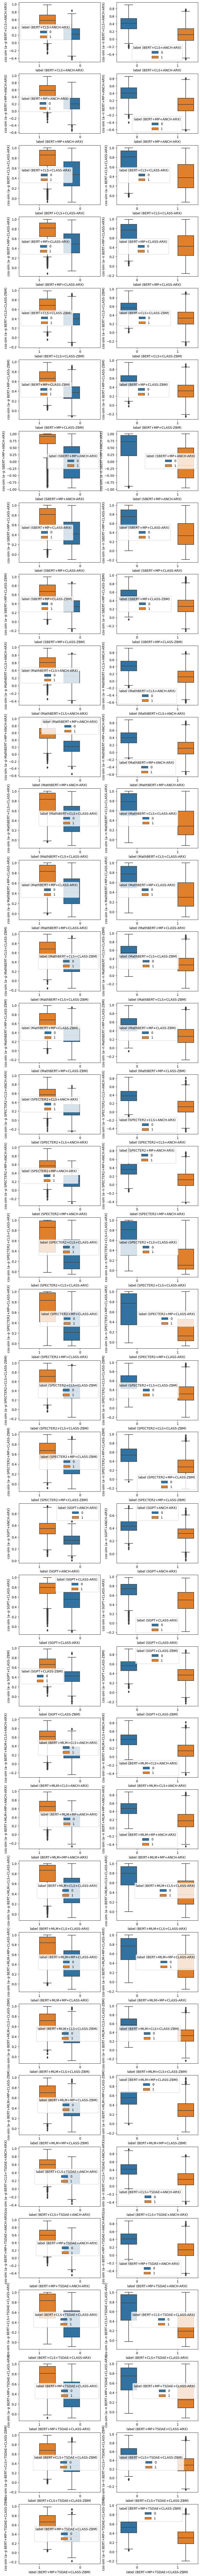

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 2, figsize=(10, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--p {})".format(n), hue="label ({})".format(n), order=[1, 0], ax=axs[i][0])
    sns.boxplot(X_test_score, x="label ({})".format(n), y="cos-sim (a--n {})".format(n), hue="label ({})".format(n), ax=axs[i][1])

## Results for test data

In [14]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,title,abstract,categories,doi,a,p,n,cos-sim (a--p BERT+CLS+ANCH-ARX),cos-sim (a--n BERT+CLS+ANCH-ARX),label (BERT+CLS+ANCH-ARX),cos-sim (a--p BERT+MP+ANCH-ARX),cos-sim (a--n BERT+MP+ANCH-ARX),label (BERT+MP+ANCH-ARX),cos-sim (a--p BERT+CLS+CLASS-ARX),cos-sim (a--n BERT+CLS+CLASS-ARX),label (BERT+CLS+CLASS-ARX),cos-sim (a--p BERT+MP+CLASS-ARX),cos-sim (a--n BERT+MP+CLASS-ARX),label (BERT+MP+CLASS-ARX),cos-sim (a--p BERT+CLS+CLASS-ZBM),...,cos-sim (a--n BERT+MLM+MP+CLASS-ZBM),label (BERT+MLM+MP+CLASS-ZBM),cos-sim (a--p BERT+CLS+TSDAE+ANCH-ARX),cos-sim (a--n BERT+CLS+TSDAE+ANCH-ARX),label (BERT+CLS+TSDAE+ANCH-ARX),cos-sim (a--p BERT+MP+TSDAE+ANCH-ARX),cos-sim (a--n BERT+MP+TSDAE+ANCH-ARX),label (BERT+MP+TSDAE+ANCH-ARX),cos-sim (a--p BERT+CLS+TSDAE+CLASS-ARX),cos-sim (a--n BERT+CLS+TSDAE+CLASS-ARX),label (BERT+CLS+TSDAE+CLASS-ARX),cos-sim (a--p BERT+MP+TSDAE+CLASS-ARX),cos-sim (a--n BERT+MP+TSDAE+CLASS-ARX),label (BERT+MP+TSDAE+CLASS-ARX),cos-sim (a--p BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (a--n BERT+CLS+TSDAE+CLASS-ZBM),label (BERT+CLS+TSDAE+CLASS-ZBM),cos-sim (a--p BERT+MP+TSDAE+CLASS-ZBM),cos-sim (a--n BERT+MP+TSDAE+CLASS-ZBM),label (BERT+MP+TSDAE+CLASS-ZBM)
68558,Consumption investment optimization with Epste...,In a market with stochastic investment oppor...,"('math.PR', 'q-fin.PM')",NaN,The empirically relevant utility specification...,In a market with stochastic investment opport...,"In the second part, we establish the solvabili...",0.656808,-0.112516,1,0.747958,0.321883,1,0.705421,0.482558,1,0.585782,0.322843,1,0.338409,...,0.245784,1,0.588398,0.106213,1,0.407625,0.082373,1,0.423615,0.218738,1,0.288303,0.312154,0,0.520902,0.185927,1,0.574630,0.360914,1
61220,The Brauer-Manin obstruction for stacky curves,We show that the Brauer-Manin obstruction is...,"('math.AG', 'math.NT')",NaN,We will furthermore show that the elementary o...,We then compute the Brauer-Manin obstruction f...,Conjectures involving infinite families of re...,0.861300,-0.030933,1,0.841547,0.091999,1,0.942096,0.036313,1,0.989786,0.166917,1,0.977408,...,0.216383,1,0.757639,0.171773,1,0.732590,0.075454,1,0.991099,-0.074685,1,0.954808,-0.037371,1,0.891028,0.524458,1,0.956424,0.487916,1
34522,Extending wavelet filters. Infinite dimensions...,In this paper we are discussing various aspe...,"('math.CV', 'math.FA')",NaN,"We focus on the non-rational case, and establi...","Motivated by applications, and by bringing to ...",We establish system of equations for single f...,0.702319,-0.136897,1,0.780220,-0.141883,1,0.941238,0.922371,1,0.937912,0.829508,1,0.535843,...,0.405829,1,0.724322,0.234373,1,0.651124,0.085439,1,0.954661,0.394899,1,0.974404,0.880006,1,0.869697,0.374416,1,0.724747,0.381532,1
54170,Michel theory of symmetry breaking and gauge t...,We extend Michel's theorem on the geometry o...,"('math-ph', 'math.MP')",10.1006/aphy.1997.5700,of gauge-invariant functionals defined on the ...,We extend Michel's theorem on the geometry of...,We study the anisotropic version of the Hasti...,0.139395,0.061244,1,0.383260,0.160957,1,0.669886,0.015365,1,0.591641,0.337827,1,0.708139,...,0.440894,0,0.158367,0.001876,1,0.059455,0.166035,0,0.114471,0.125703,0,0.073376,0.369027,0,0.417361,0.340199,1,0.371460,0.319568,1
55184,Convergence Analysis of Virtual Element Method...,"In this article, we have considered a nonlin...","('math.NA', 'cs.NA', 'math.AP')",NaN,"Finally, numerical experiments are presented t...",We employ VEM to discretize the space variable...,For this second class of problems a special ve...,0.684968,0.744979,0,0.600504,0.775944,0,0.929365,0.304055,1,0.639879,0.411872,1,0.768946,...,0.232678,1,0.671460,0.705838,0,0.653823,0.448565,1,0.980381,0.057004,1,0.939796,0.149359,1,0.870392,0.253296,1,0.861668,0.488051,1
24020,Simion's type $B$ associahedron is a pulling t...,We show that Simion's type $B$ associahedron...,"('math.CO',)",NaN,"Finally, we present a bijection between the fa...","Furthermore, we show that every pulling triang...",This class contains all matr